# Topic trend analysis
This notebook explaines steps involved in  study of news trends during June 2013 including:
* Preprocessing a corpus of articles text documents 
* Topic Modeling using LDA
* Topic interactive Visualization
* Topic trends analysis
 

## Text Preprocessing

### Loading data
In this section I explore the input data to check:
* number of missing values for each features
* number of articles per language


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
corpus= pd.read_csv('rna002_RTRS_2013_06.csv',encoding='utf-8')

In [3]:
## Missing value counts , total number of articles:421993
corpus.shape[0]-corpus.isnull().sum()


DATE                      421993
TIME                      421993
UNIQUE_STORY_INDEX        421993
EVENT_TYPE                421993
PNAC                      421993
STORY_DATE_TIME           421993
TAKE_DATE_TIME            250616
HEADLINE_ALERT_TEXT       378840
ACCUMULATED_STORY_TEXT     17699
TAKE_TEXT                 171372
PRODUCTS                  379255
TOPICS                    379255
RELATED_RICS              151626
NAMED_ITEMS               102028
HEADLINE_SUBTYPE          155596
STORY_TYPE                379255
TABULAR_FLAG              379255
ATTRIBUTION               379255
LANGUAGE                  379255
dtype: int64

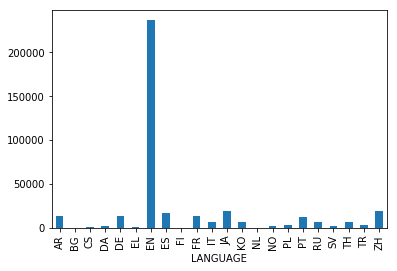

In [4]:
corpus.groupby(['LANGUAGE'])['DATE'].count().plot.bar()
plt.show()

### Filtering data
* The majority of articles are in English so I only consider English articles. The same pipeline can be extended to other language as long as text pre-processing steps are adopted to that language. 
* In this analysis only articles that have main text story are considered

In [5]:
stories =corpus.HEADLINE_ALERT_TEXT[(corpus.LANGUAGE=='EN')& ~(corpus.ACCUMULATED_STORY_TEXT.isnull())].values
ind = corpus.HEADLINE_ALERT_TEXT[(corpus.LANGUAGE=='EN')& ~(corpus.ACCUMULATED_STORY_TEXT.isnull())].index

### Text preprocessing 
I apply following processing on each article to get list of words:
* Tokenization
* Lemmatization
* Lower casing
* Punctuation removal
* Stopwords removal
* Frequent words removal
* Rare words removal
* Removing numbers and word containing numbers
* Removing URLS and email adresses

In [6]:
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')

custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )


def clean(doc):
    doc.encode("utf8")
    doc= re.sub("https?:\/\/.*[\r\n]*", "", doc)
    doc = re.sub('\S*@\S*\s?','',doc)
    doc = re.sub('[^a-zA-Z0-9\n\.]', ' ', doc)
    tokens =word_tokenize(doc)
    tokens = [re.sub('[^A-Za-z0-9]+', '', word.lower()) for word in tokens]
    tokens = [ word for word in tokens  if all([not e.isdigit() for e in word])]
    tokens=  [word for word in tokens if len(word)>4]
    tokens = [word for word in tokens if word not in custom_stop_words]
    tokens = [word for word in tokens if word not in exclude]
    tokens = [word for word in tokens if not word.isdigit()]
    tokens = [lemma.lemmatize(word) for word in tokens ]
    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/schoobdar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/schoobdar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
clean_data =[clean(unicode(doc)) for doc in stories]


In [8]:
#### Remove frequent and rare words
from collections import Counter
words_count = sorted(Counter([i for items in clean_data for i in items]).items(),key=lambda x:x[1])


#### Word Counts
In this section I explored the word counts in the whole corpus to decide about frequent words and rare one regarding their counts.

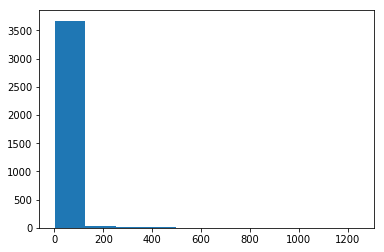

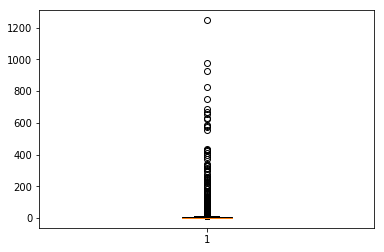

In [19]:
import matplotlib.pyplot as plt
plt.hist([i[1] for i in words_count])
plt.show()

plt.boxplot([i[1] for i in words_count ])
plt.show()

#### Word Cloud

Here I tried to get some idea of quality of my preprocessing by visualizing word counts in the format of word cloud.

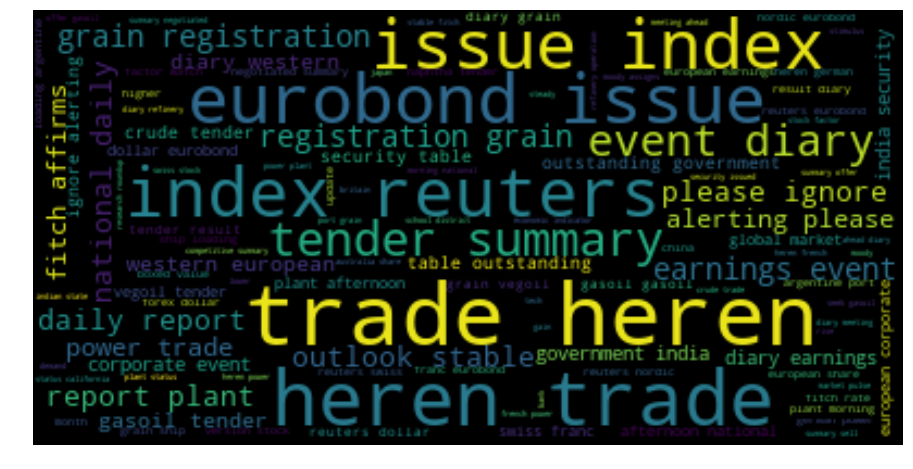

In [10]:
from wordcloud import WordCloud
# Generate a word cloud image
text = ' '.join([i for items in clean_data for i in items])
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
freq=[x[0] for x in words_count[-100:]]
rare= [x[0] for x in words_count if x[1]==1]


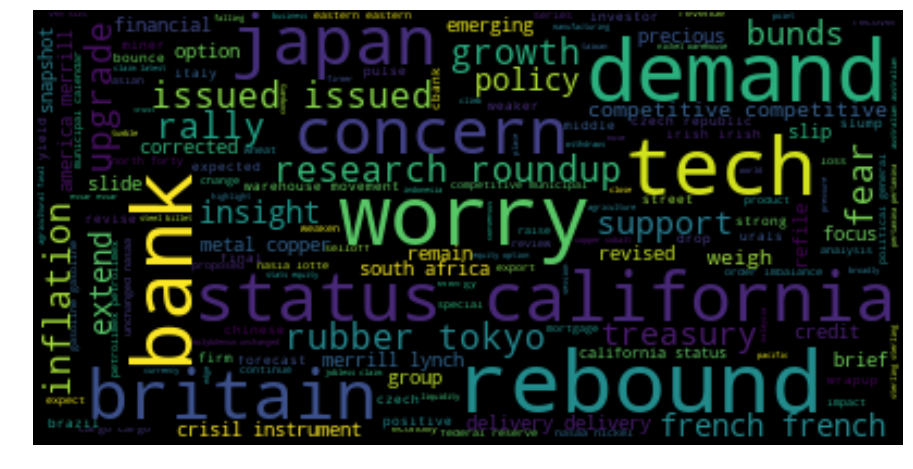

In [12]:
clean_data =[[i for i in items if i not in freq+rare] for items in clean_data]
from wordcloud import WordCloud
# Generate a word cloud image
text = ' '.join([i for items in clean_data for i in items])
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modeling using LDA
Latent Dirichlet Allocation (LDA) is the most popular topic modeling technique. LDA is a  matrix factorization technique that converts  Document-Term Matrix to into two lower dimensional matrices – M1 and M2.
M1 is a document-topics matrix and M2 is a topic – terms matrix.

### Building Document-Term Matrix
In this section a dictionary from the data is built and converted to bag-of-words corpus. I set number of topics to 10.

In [13]:
from gensim import corpora
dictionary = corpora.Dictionary(clean_data)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_data]

In [96]:
import gensim
NUM_TOPICS = 10
# Creating the object for LDA model using gensim library
# Running and  LDA model on the document term matrix.

ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, u'0.037*"french" + 0.029*"pulse" + 0.025*"rally" + 0.022*"revised"')
(1, u'0.044*"california" + 0.041*"status" + 0.035*"australian" + 0.035*"bank"')
(2, u'0.044*"unchanged" + 0.033*"eastern" + 0.031*"gasoline" + 0.028*"supply"')
(3, u'0.044*"fear" + 0.023*"final" + 0.022*"energy" + 0.019*"growth"')
(4, u'0.041*"italy" + 0.028*"upgrade" + 0.024*"north" + 0.022*"support"')
(5, u'0.037*"operation" + 0.028*"copper" + 0.025*"tech" + 0.023*"ceypetco"')
(6, u'0.030*"order" + 0.029*"option" + 0.029*"research" + 0.028*"competitive"')
(7, u'0.036*"precious" + 0.035*"essar" + 0.030*"consensus" + 0.029*"quarter"')
(8, u'0.039*"japan" + 0.027*"investor" + 0.024*"bunds" + 0.024*"policy"')
(9, u'0.042*"cargo" + 0.037*"delivery" + 0.031*"czech" + 0.030*"mortgage"')


## Visualizing the topics and related terms
This visualization helps users to interpret the topics in a topic model. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

Saliency: a measure of how much the term tells you about the topic.

Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

The size of the bubble measures the importance of the topics, relative to the data.



In [97]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/schoobdar/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


# Tending Topics
In this section I looked at the topics trends by following steps:
* Find most relevant topic for each article
* Build a time series of number of articles for each topic
* Look at the trend for time series of topics
* Find trendiness score for each topic using z-score model

In [98]:
#### finding trends
topic_trend=[]
for i in range(len(ind)):
    t = corpus.loc[ind[i],'DATE']
    p= sorted(ldamodel.get_document_topics(doc_term_matrix[i]),key=lambda x:x[1])[-1][0]
    topic_trend.append([t,p,1])
    

In [99]:
import numpy as np
topic_counts = pd.DataFrame(np.array(topic_trend),columns=['date','topic','d']).groupby(['date','topic'])['d'].count().unstack()
topic_counts[topic_counts.isnull()]=0
topic_counts.head()

topic,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2013-06-01,0.0,2.0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0
2013-06-02,2.0,11.0,2.0,3.0,5.0,5.0,0.0,2.0,1.0,2.0
2013-06-03,37.0,40.0,40.0,29.0,34.0,49.0,28.0,45.0,41.0,225.0
2013-06-04,23.0,26.0,23.0,40.0,31.0,25.0,29.0,35.0,32.0,216.0
2013-06-05,35.0,43.0,61.0,28.0,24.0,49.0,39.0,39.0,34.0,235.0


## Topics Time seris
Topics follow a weakly pattern so I used time series seasonal decomposition method to extract the trend. Then I canculated a Z-score for each topic in the last five days of the month to check the trendiness. This is the standard algorithm to find trending items and calculated as:
\begin{align}
z=(x-\mu)/\sigma
\end{align}

where $\mu$ is the history mean and $\sigma$ is the standard deviation of the history data. In the following code, for every point, the above formula is re-applied with a decay factor so that the oldest points carry the less factor value.

When a z-score is used, the higher or lower the z-score the more abnormal the trend, so for example if the z-score is highly positive then the trend is abnormally rising, while if it is highly negative it is abnormally falling. Hence, the z-score for all the candidate trends the highest top_n z-scores will relate to the most abnormally increasing z-scores.

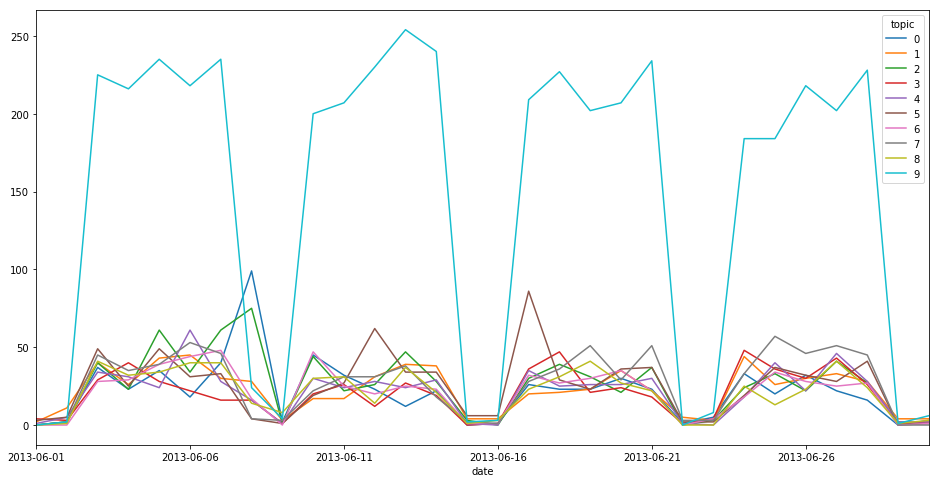

In [100]:
topic_counts.plot(figsize=(16,8))
plt.show()

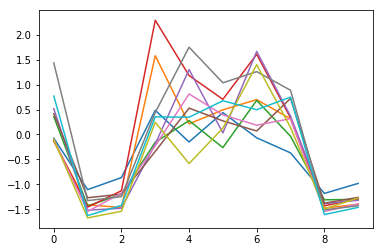

In [101]:
from math import sqrt

def zscore(obs, pop):
    # Size of population.
    number = float(len(pop))
    # Average population value.
    avg = sum(pop) / number
    # Standard deviation of population.
    std = sqrt(sum(((c - avg) ** 2) for c in pop) / number)
    # Zscore Calculation.
    return (obs - avg) / std
def rolling_zscore(obs,wt=3):   
        return [zscore(obs[i],obs[:i])  for i in range(wt,len(obs))]
# plt.figure(figsize=(16,8))
for i in topic_counts.columns:
    wt=20
    plt.plot(rolling_zscore(topic_counts[i],wt))
plt.legend(loc='upper left')
plt.show()


(u'0', -0.6838243444644154)
(u'1', 0.14030592554785354)
(u'2', -0.8278652114091627)
(u'3', 2.0698962050842833)
(u'4', 0.009995966251506)
(u'5', -1.0436047532767319)
(u'6', -0.7884385974596033)
(u'7', 1.3098226675875329)
(u'8', -0.9835535973182448)
(u'9', -1.7164219423900902)


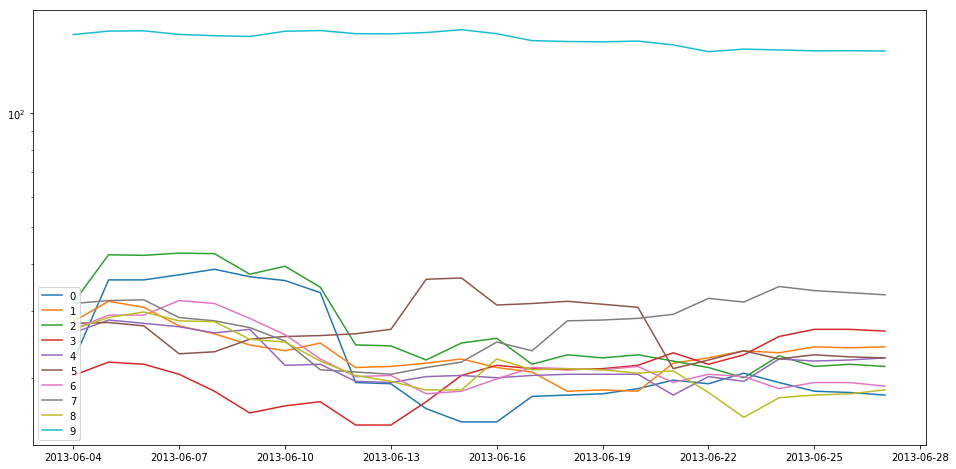

In [102]:
import statsmodels.api as sm

topic_counts['date'] = pd.to_datetime(topic_counts.index)
topic_counts = topic_counts.set_index('date')
# print (s.resid)
# print(s.seasonal)
# print(s.trend)
plt.figure(figsize=(16,8))
topic_trending= []
for i in topic_counts.columns:
    s=sm.tsa.seasonal_decompose(topic_counts[i])
#     plt.plot(rolling_zscore(s.trend.values,wt))

    plt.plot(s.trend)
    
    plt.yscale('log')
    print (i,(s.trend[-5]-s.trend[:-5].mean())/s.trend[:-5].std())
    topic_trending.append([i,(s.trend[-5]-s.trend[:-5].mean())/s.trend[:-5].std()])
plt.legend(loc='lower left')
plt.show()

## Most Trending topics

In [104]:
sorted(topic_trending, key=lambda x:abs(x[1]),reverse=True)

[[u'3', 2.0698962050842833],
 [u'9', -1.7164219423900902],
 [u'7', 1.3098226675875329],
 [u'5', -1.0436047532767319],
 [u'8', -0.9835535973182448],
 [u'2', -0.8278652114091627],
 [u'6', -0.7884385974596033],
 [u'0', -0.6838243444644154],
 [u'1', 0.14030592554785354],
 [u'4', 0.009995966251506]]

# Future works

There are some areas to improve in this analysis:
* Adding articles from other languages
* exploring more text pre-processing options
* Optimizing number of topics for LDA
* Extending trendig score (Z-score): in this analysis only daily trendig topics are detected we can extend it to larger time window by having more historical data